In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


That's great, we don't have any null in our data

## EDA

Let's check the distribution of age


<img src="https://media2.giphy.com/media/8JrcyXvpOaFbFIatkm/giphy.gif?cid=ecf05e470s9jkirkdnrg7dmysp4jotghq8hkkrfu6niiword&rid=giphy.gif&ct=g">

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Age')

<Figure size 864x288 with 0 Axes>

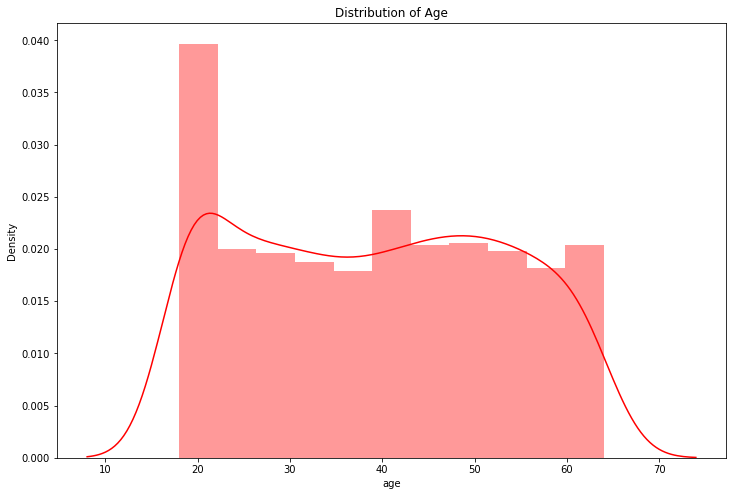

In [4]:
f= plt.figure(figsize=(12,4))
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['age'], kde = True, color = 'r')
plt.title('Distribution of Age')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Insurance Charges')

<Figure size 864x288 with 0 Axes>

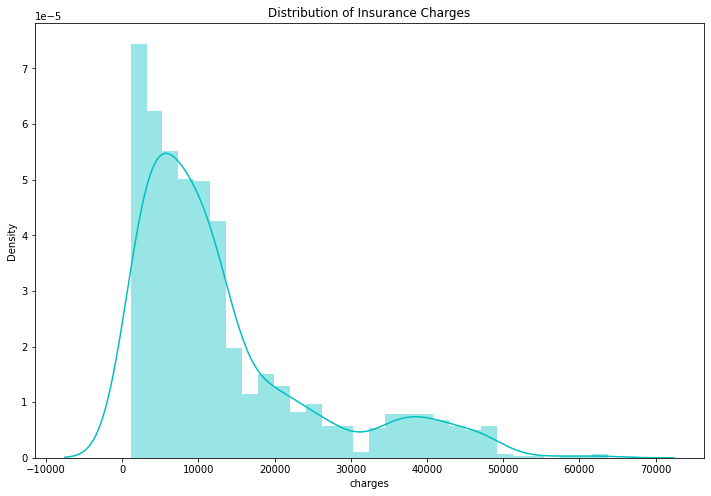

In [5]:
f= plt.figure(figsize=(12,4))
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['charges'], kde = True, color = 'c')
plt.title('Distribution of Insurance Charges')

Here is the distribution of our dependent variable "y" and we have a right-skewed distribution. To make it closer to normal we can apply natural log.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


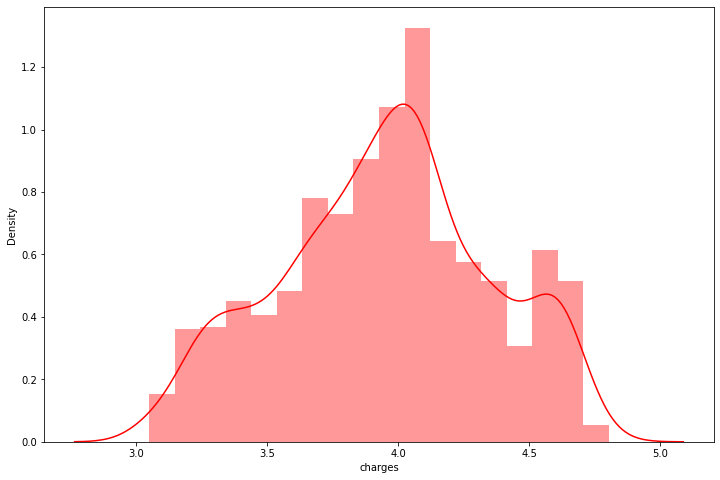

In [6]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log10(df['charges']), kde = True, color = 'r' )

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


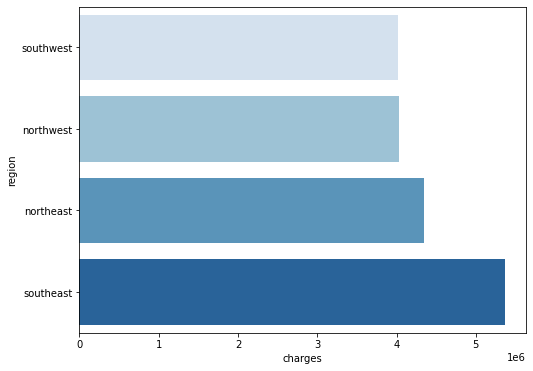

In [7]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(charges.head(), charges.head().index, palette='Blues')

So Southeast has the highest medical charges  and Southwest has the lowest. Taking into account certain factors (sex, smoking, having children) let's see how it changes by region

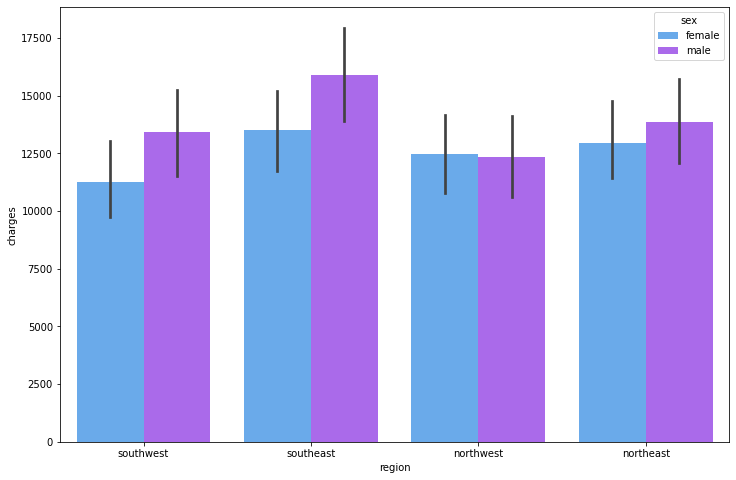

In [8]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

Let's check the Smoker data.    Smokers are paying high charges 


<img src="https://64.media.tumblr.com/30e4148d71908c9d41c5888808e8b00b/tumblr_mzoql331JV1tohycao1_400.gifv">

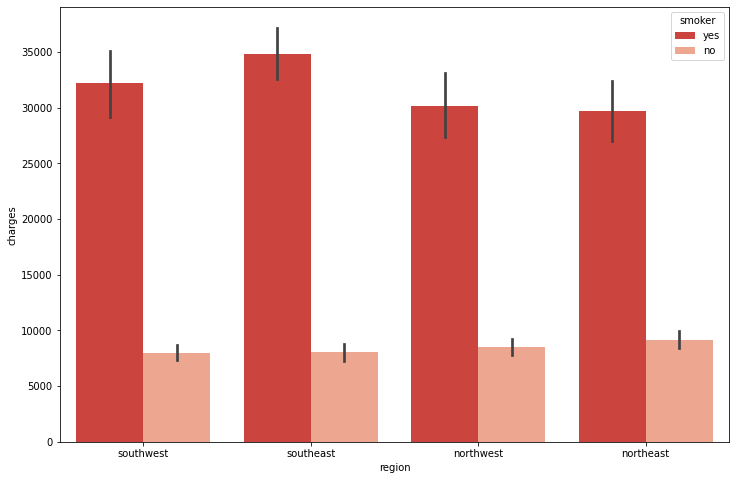

In [9]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='Reds_r')

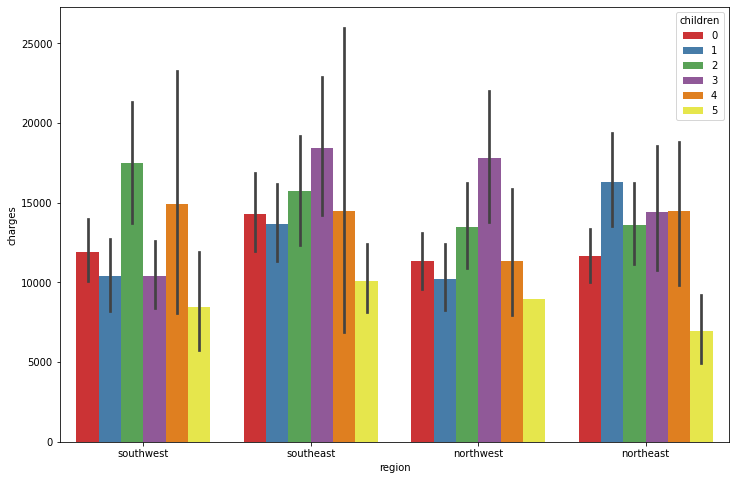

In [10]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')

As we can see from these barplots the highest charges due to smoking are still in the Southeast but the lowest are in the Northeast. People in the Southwest generally smoke more than people in the Northeast, but people in the Northeast have higher charges by gender than in the Southwest and Northwest overall. And people with children tend to have higher medical costs overall as well

Now let's analyze the medical charges by age, bmi and children according to the smoking factor


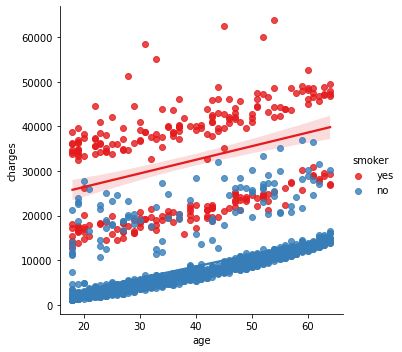

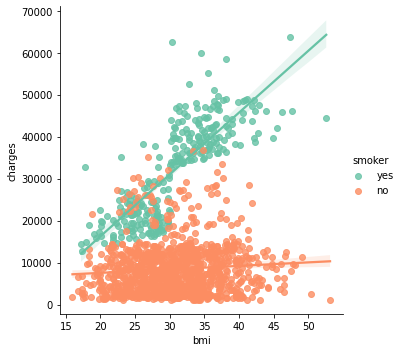

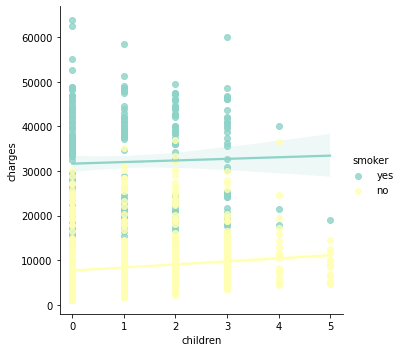

In [11]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

Smoking has the highest impact on medical costs, even though the costs are growing with age, bmi and children. Also people who have children generally smoke less, which the following violinplots shows too

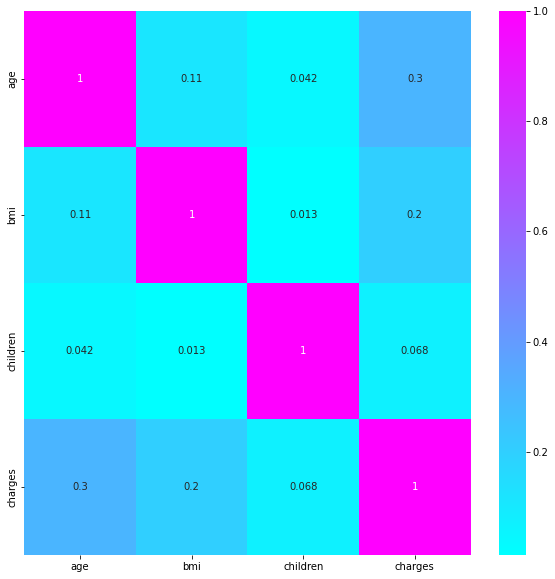

In [12]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='cool')

# Feature scaling

In [13]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [14]:
ct = make_column_transformer((
    StandardScaler(),["age","bmi","children"]),(OneHotEncoder(handle_unknown="ignore"),["sex","smoker","region"])
)

In [15]:
X = df.drop("charges",axis=1)
y = df["charges"]

In [16]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
ct.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'smoker', 'region'])])

In [18]:
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

To Solve this Regression problem we have multiple model like .. 

LinearRegression, 
Ridge, 
Lasso,
DecisionTreeRegressor,
KNeighborsRegressor,
SVR,
random_forest, 
AdaBoostRegressor, 
XGBRegressor,
LGBMRegressor,

And we have deep learning models also ... How to decide best among them ....


<img src="https://64.media.tumblr.com/3d343789f4fea02d39f249fa9c3703f0/tumblr_n156u4CNjE1tstqaho1_500.gifv">

We will take help of grid search

In [19]:
model_param = {
    'LinearRegression':{
        'model' : LinearRegression(),
        'param' : {}
    },
    'Ridge':{
        'model' : Ridge(),
        'param' : {
            'alpha': [0.5,0.75]
        }
    },
    'Lasso':{
        'model' : Lasso(fit_intercept=True, normalize=False, precompute=False,warm_start=False, positive=False, random_state=None, selection='cyclic'),
        'param' : {
            'alpha': [0.2, 0.3,0.5],
            'tol':[0.0001,0.001, 0.01, 0.1]
        }
    },
    'DecisionTreeRegressor':{
        'model':DecisionTreeRegressor(),
        'param':{
            'criterion': ['mse', 'friedman_mse', 'mae']
        }
    },
    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'param':{
            'n_neighbors':[5,10,15,20,25]
        }
    },
    'SVR':{
        'model': SVR(),
        'param': {
            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'C':[1,5,10,20,30,50,80,100]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'param' : {
            'criterion': ['mse','mae'],
            'n_estimators': [1000,1200,1500,2000,3000]
        }
    },
    'AdaBoostRegressor':{
        'model': AdaBoostRegressor(),
        'param':{
            "n_estimators": [1, 10,100],
            'learning_rate':[.001,0.01,.1]
        }
    },
    'XGBRegressor':{
        'model' : XGBRegressor(),
        'param':{
            'booster': ['gbtree','dart'],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'max_depth': [3, 4, 5]
        }
    },
    'lgb':{
        'model':LGBMRegressor(),
        'param':{'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]
                 }
    }
}

In [20]:
import warnings
warnings.filterwarnings('ignore')

scores =[]
for model_name, mp in model_param.items():
    model_selection = GridSearchCV(estimator=mp['model'],param_grid=mp['param'],cv=5,return_train_score=False)
    model_selection.fit(X_train_normal,y_train)
    scores.append({
        'model': model_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [21]:
df_model_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_model_score

,model,best_score,best_params
0,LinearRegression,0.733040,{}
1,Ridge,0.733137,{'alpha': 0.75}
2,Lasso,0.733132,"{'alpha': 0.5, 'tol': 0.1}"
3,DecisionTreeRegressor,0.711414,{'criterion': 'friedman_mse'}
4,KNeighborsRegressor,0.753616,{'n_neighbors': 5}
5,SVR,0.556230,"{'C': 100, 'kernel': 'linear'}"
6,random_forest,0.829540,"{'criterion': 'mse', 'n_estimators': 3000}"
7,AdaBoostRegressor,0.841148,"{'learning_rate': 0.001, 'n_estimators': 100}"
8,XGBRegressor,0.825215,"{'booster': 'dart', 'gamma': 0.5, 'max_depth': 3}"
9,lgb,-1.242024,"{'boosting_type': 'gbdt', 'colsample_bytree': ..."


In [22]:
AdaBoostRegressor = AdaBoostRegressor(learning_rate= 0.001, n_estimators= 100)

In [23]:
AdaBoostRegressor.fit(X_train_normal,y_train)

AdaBoostRegressor(learning_rate=0.001, n_estimators=100)

In [24]:
y_pred_ada = AdaBoostRegressor.predict(X_test_normal)

<AxesSubplot:xlabel='charges', ylabel='Density'>

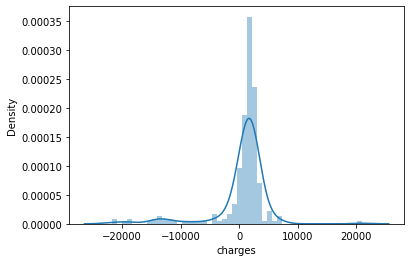

In [25]:
sns.distplot(y_pred_ada-y_test)

In [26]:
Abd_mae = mean_absolute_error(y_test,y_pred_ada)
Abd_mae

2882.820688480914

### Appling deep earning approach

In [27]:
import tensorflow as tf
import numpy as np

2021-09-16 22:25:08.980240: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-16 22:25:08.980359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [28]:
tf.random.set_seed(42)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.mae,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['mae'])



2021-09-16 22:25:14.371186: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 22:25:14.374619: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-16 22:25:14.374652: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-16 22:25:14.374677: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (78293f636b73): /proc/driver/nvidia/version does not exist
2021-09-16 22:25:14.375058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [30]:
history = model.fit(X_train_normal,y_train,epochs=200)

2021-09-16 22:25:14.627934: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 22:25:14.646304: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/200
34/34 [==============================] - 1s 1ms/step - loss: 13296.9441 - mae: 13296.9441
Epoch 2/200
34/34 [==============================] - 0s 1ms/step - loss: 12950.6186 - mae: 12950.6186
Epoch 3/200
34/34 [==============================] - 0s 1ms/step - loss: 12711.6362 - mae: 12711.6362
Epoch 4/200
34/34 [==============================] - 0s 1ms/step - loss: 13385.4328 - mae: 13385.4328
Epoch 5/200
34/34 [==============================] - 0s 1ms/step - loss: 13262.7164 - mae: 13262.7164
Epoch 6/200
34/34 [==============================] - 0s 1ms/step - loss: 13053.1331 - mae: 13053.1331
Epoch 7/200
34/34 [==============================] - 0s 1ms/step - loss: 12971.0795 - mae: 12971.0795
Epoch 8/200
34/34 [==============================] - 0s 1ms/step - loss: 13150.5917 - mae: 13150.5917
Epoch 9/200
34/34 [==============================] - 0s 1ms/step - loss: 12717.8282 - mae: 12717.8282
Epoch 10/200
34/34 [==============================] - 0s 1ms/step - loss: 12598.51

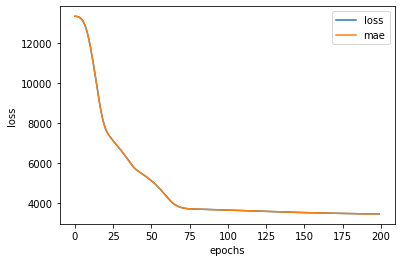

In [31]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [32]:
model_loss,model_mae = model.evaluate(X_test_normal,y_test)
model_loss,model_mae

9/9 [==============================] - 0s 1ms/step - loss: 3159.6194 - mae: 3159.6194


(3159.619384765625, 3159.619384765625)

In [33]:
y_pred_tensor = model.predict(X_test_normal)

In [34]:
y_test_tensor = np.asarray(y_test)

<AxesSubplot:ylabel='Density'>

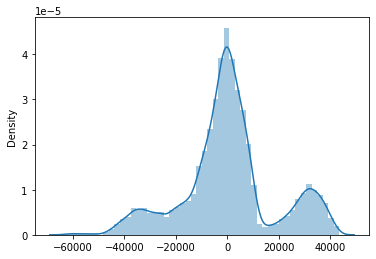

In [35]:
sns.distplot(y_pred_tensor-y_test_tensor)

### AdaBoostRegressor wins with MAE of 2897